# Cryptography Project
by Eitan Lees and Juan Llanos

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
import random
from datetime import datetime
from itertools import combinations
import string
import pandas
from collections import Counter

## Introduction

Our goal is to decipher a secret message. First let's read in the secret message to see what we are dealing with

In [2]:
with open ("data/encyrption.txt", "r") as myfile:
    message=myfile.read().replace('\n', '')

print(message)

BIU V DICT ZMEF VBZFU MZ NVJ OJGFUFL MCZI ZGMJ NIUDL IB JIUUIN VCL ZUIOQDF QK ZGF HVUMJG JOUTFIC MZ UFEVMCFL V EVZZFU IB PICJMLFUVQDF LIOQZ NGFZGFU ZGF PGMDL NIODL JOURMRF ZI QFVU VCK CVEF VZ VDD MC NGMPG PVJF MZ MJ JIEFNGVZ EIUF ZGVC HUIQVQDF ZGVZ ZGFJF EFEIMUJ NIODL CFRFU GVRF VHHFVUFL IU MB ZGFK GVL ZGVZ QFMCT PIEHUMJFL NMZGMC V PIOHDF IB HVTFJ ZGFK NIODL GVRF HIJJFJJFL ZGF MCFJZMEVQDF EFUMZ IB QFMCT ZGF EIJZ PICPMJF VCL BVMZGBOD JHFPMEFC IB QMITUVHGK FYZVCZ MC ZGF DMZFUVZOUF IB VCK VTF IU PIOCZUK 


Our principal assumption is that the secret message was coded with a unique 1-1 substitution mapping among the 26 letters of the alphabet (A $\rightarrow$ L, B $\rightarrow$ R, etc). To break the code we are going to need to find the correct maping $f$ that reveals the secret. 

$$
f : \{`A`,  `B`, \dots, `Z`, `\mbox{ }`\} \rightarrow \{`O`,  `F`, \dots, `J`, `\mbox{ }`\}
$$
Furthermore, we assume the message is written in capital letters, space will always map to space, and the message has no punctuation.

First we will need a function to generate such a maping

In [3]:
def get_map():
    alphabet = string.uppercase
    key = ''.join(random.sample(alphabet,len(alphabet)))
    myMap = dict(zip(alphabet, key))
    myMap[' '] = ' '
    return myMap

The `dict` data structure seemed like a good way to store these mappings. Lets generate a random mapping to take a look at how `get_map` works

In [4]:
myMap = get_map()
pp.pprint(myMap)

{' ': ' ',
 'A': 'F',
 'B': 'T',
 'C': 'W',
 'D': 'D',
 'E': 'K',
 'F': 'I',
 'G': 'B',
 'H': 'C',
 'I': 'Z',
 'J': 'H',
 'K': 'A',
 'L': 'Y',
 'M': 'P',
 'N': 'X',
 'O': 'M',
 'P': 'L',
 'Q': 'G',
 'R': 'J',
 'S': 'Q',
 'T': 'N',
 'U': 'U',
 'V': 'S',
 'W': 'E',
 'X': 'V',
 'Y': 'O',
 'Z': 'R'}


Now that we having mapping, $f$, we need a way to apply that mapping to encrypt or decrypt some text.

In [5]:
def encrypt(s, myMap):
    return ''.join([myMap[c] for c in list(s)])

The `encrypt` function takes a string `s` and applies the mapping `mymap` and returns the encrypted string. Lets give our new mapping a try with a test string.

In [6]:
test = 'THIS IS A SUPER SECRET MESSAGE'
secret = encrypt(test,myMap)
print secret

NCZQ ZQ F QULKJ QKWJKN PKQQFBK


Note that the way `encrypt` as been defined it is not reversable but a `decrypt` function could be implemented

In [7]:
def decrypt(s, myMap):
    inv_map = {v: k for k, v in myMap.items()}
    return ''.join([inv_map[c] for c in list(s)])

By applying the inverted mapping to the encrypted secret we should recover the origial message

In [8]:
anothertest = decrypt(secret, myMap)
print anothertest

THIS IS A SUPER SECRET MESSAGE


## Methods

In order decode the message we need to find the inverse mapping

$$f^{-1}:\{`P`, `T`, \dots, `O`, `\mbox{ }`\} \rightarrow \{`A`, `B`, \dots, `Z`, `\mbox{ }`\}$$

To crack this code we are going to utilize a matrix $M_{ij}$ that represents the transition frequency from the $i^{th}$ letter of the alphabet to the $j^{th}$. This matrix was calculated using "War and Peace", "Oliver Twist", and
"King James Bible" from Project Gutenberg and was provided for the assignment. Now we will read in the pair frequence matrix for the 26 letters of the alphabet and also the space character

In [9]:
pairFreq = np.loadtxt('data/pairFreq.dat')
pairFreq.shape

(27, 27)

We implemented two ways to tackle this problem: an optimization approach, and a sampling approach.

### Optimization Approach

First we chose to approach the problem from an optimization perspective. This method will quickly converge on the most likely outcome by maximizing a rank function outlined below.

We rank a string as being english if the sum of the $M_{ij}$ is maximized
$$
R(f) = \sum_{i=1}^{N-1} M(f(s_i), f(s_{i+1}))
$$
where $N$ is the number of letters in the message, and $s_i$ is the $i^{th}$ letter of the encrypted message. This approach was chosen to avoid the effects of logging the zero elements in the frequency matrix. Using an additive rank avoids this problem but will behave differently than the multiplicative ranking outlined in the instructions. We define our rank fucntion as such

In [10]:
def rate_string(M, s):
    lookup = string.uppercase + ' '
    return np.sum(M[lookup.find(s[i])][lookup.find(s[i+1])] for i in range(len(s) - 1))

where `M` is the pairwise frequency matrix and `s` is a string to be ranked. Our strategy will be to rank the current string, then apply our mapping to generate a new string, and test to see if our new string had a better ranking. If our mapping doesn't increase the rank then we will swap two of the letters in our mapping and again test to see if this new mapping provides a better ranked string. If the rank is better than the new mapping is kept and the process is repeated. The last function needed to attempt this algorithm is one to perform these swaps

In [11]:
def key_swap(myMap, swap_pick):
    swapMap = dict(myMap)
    swapMap[swap_pick[0]] = myMap[swap_pick[1]]
    swapMap[swap_pick[1]] = myMap[swap_pick[0]]
    return swapMap

Here `myMap` is the mapping and `swap_pick` is a randomly generated string of the letters you want to swap. Now all that is left is to write a driver function to perform the optimization

In [12]:
def MC_decrypt(oldS, M, myMap, nsteps = 1000):
    
    allSwaps = [''.join(i) for i in combinations(string.uppercase, 2)]
    p = rate_string(pairFreq, oldS)
    newp = 0.0
    oldmap = dict(myMap)
    t = 0
    t0 = datetime.now()
    for i in range(nsteps):
        mySwap = allSwaps[random.randint(0,len(allSwaps)-1)]
        newmap = dict(key_swap(oldmap, mySwap))
        newS = encrypt(oldS, newmap)
        newp = rate_string(pairFreq, newS)
        if(p < newp):
            oldmap = dict(newmap)
            p = newp
            t += 1

    t1 = datetime.now()
    tdiff = t1-t0

    #print "Total run time: " + str(tdiff)[2:10] + "s"
    #print "p = " + str(p)
    #print "Acceptance Ratio = " + str(100*float(t)/float(nsteps)) + '%'
    return encrypt(oldS, oldmap)

It's important to note here that we always accept the change if it increases our rank. This is known as "simulated quenching" and is useful for a local optimization but might get stuck, not finding the global maxima. 

### Optimization Results
Lets run our simulation to see what we get

In [13]:
MC_decrypt(message, pairFreq, myMap)

'FUR A LUNG TIME AFTER IT OAS PSHERED INTU THIS OURLD UF SURRUO AND TRUPBLE BY THE WARISH SPRGEUN IT REMAINED A MATTER UF CUNSIDERABLE DUPBT OHETHER THE CHILD OUPLD SPRVIVE TU BEAR ANY NAME AT ALL IN OHICH CASE IT IS SUMEOHAT MURE THAN WRUBABLE THAT THESE MEMUIRS OUPLD NEVER HAVE AWWEARED UR IF THEY HAD THAT BEING CUMWRISED OITHIN A CUPWLE UF WAGES THEY OUPLD HAVE WUSSESSED THE INESTIMABLE MERIT UF BEING THE MUST CUNCISE AND FAITHFPL SWECIMEN UF BIUGRAWHY EXTANT IN THE LITERATPRE UF ANY AGE UR CUPNTRY '

If we run the same simulation again using the same intial conditions we might get different results due to the effects of simulated quneching. 

In [14]:
MC_decrypt(message, pairFreq, myMap)

'FOR A LONG TIME AFTER IT WAS USHERED INTO THIS WORLD OF SORROW AND TROUBLE BY THE PARISH SURGEON IT REMAINED A MATTER OF CONSIDERABLE DOUBT WHETHER THE CHILD WOULD SURVIVE TO BEAR ANY NAME AT ALL IN WHICH CASE IT IS SOMEWHAT MORE THAN PROBABLE THAT THESE MEMOIRS WOULD NEVER HAVE APPEARED OR IF THEY HAD THAT BEING COMPRISED WITHIN A COUPLE OF PAGES THEY WOULD HAVE POSSESSED THE INESTIMABLE MERIT OF BEING THE MOST CONCISE AND FAITHFUL SPECIMEN OF BIOGRAPHY EXTANT IN THE LITERATURE OF ANY AGE OR COUNTRY '

We could try to increase the number of steps but we will just remain stuck in the local minima. A way to remedy this problem is to run the decryption multiple times and see if there is a most common output

In [15]:
multi_run = np.array([list(MC_decrypt(message, pairFreq, myMap)) for i in range(10)])

we will need to transpose the output so that each row represents all of the outputs for a given character of our message

In [16]:
letter_cols = zip(*multi_run)

Now we can find the mode of each character position to find the final expected output

In [17]:
''.join( c for c in [Counter(letter_cols[x]).most_common(1)[0][0] for x in range(len(letter_cols))])

'FOR A LONG TIME AFTER IT WAS USHERED INTO THIS WORLD OF SORROW AND TROUBLE BY THE PARISH SURGEON IT REMAINED A MATTER OF CONSIDERABLE DOUBT WHETHER THE CHILD WOULD SURVIVE TO BEAR ANY NAME AT ALL IN WHICH CASE IT IS SOMEWHAT MORE THAN PROBABLE THAT THESE MEMOIRS WOULD NEVER HAVE APPEARED OR IF THEY HAD THAT BEING COMPRISED WITHIN A COUPLE OF PAGES THEY WOULD HAVE POSSESSED THE INESTIMABLE MERIT OF BEING THE MOST CONCISE AND FAITHFUL SPECIMEN OF BIOGRAPHY EXTANT IN THE LITERATURE OF ANY AGE OR COUNTRY '

It appears that our secret message was a quote from "Oliver Twist". With this method we can avoid depending on a single decryption that may have been stuck in a local maxima. 
The relatively short single decryption time (less than a second) allows for multiple runs to be used to build the most common result.

### Sampling Approach

In the sampling approach we explore a representative distribution of "likelihood" probabilities. We now rank a string as being english if the product of the $M_{ij}$ is maximized
$$
\mbox{PI}(f) = \prod_{i=1}^{N-1} M(f(s_i),f(s_{i+1}))
$$
where $N$ is the number of letters in the message, and $s_i$
is the $i^{th}$ letter of the encrypted message.

However, to guard against underflow and overflow, we add a small $\epsilon$ to the values of $M_{ij}$ and work with the logarithm of $\mbox{PI}(f)$. Thus, our likelihood function becomes:

$$
\log \mbox{PI}(f) = \sum_{i=1}^{N-1} \log M(f(s_i),f(s_{i+1}))
$$

In [18]:
newM = pairFreq + 1e-30

In [19]:
def log_rate_string(M, s):
    lookup = string.uppercase + ' '
    return np.sum(np.log(M[lookup.find(s[i])][lookup.find(s[i+1])]) for i in range(len(s) - 1))

Since we are now working with log values of PI we take the differnce to determine the ratio and then exponentiate the result

In [20]:
def samp_MC_decrypt(oldS, M, myMap, nsteps = 3000):
    
    allSwaps = [''.join(i) for i in combinations(string.uppercase, 2)]
    p = log_rate_string(M, oldS)
    newp = 0.0001
    oldmap = dict(myMap)
    t = 0
    t0 = datetime.now()
    recP = []
    recPstr = []
    for i in range(nsteps):
        mySwap = allSwaps[random.randint(0,len(allSwaps)-1)]
        newmap = dict(key_swap(oldmap, mySwap))
        newS = encrypt(oldS, newmap)
        newp = log_rate_string(M, newS)
        ratio  = newp - p
        recP.append(p)
        if(np.exp(ratio) > np.random.rand()):
            oldmap = dict(newmap)
            p = newp
            t += 1

    t1 = datetime.now()
    tdiff = t1-t0

    print "Total run time: " + str(tdiff)[2:10] + "s"
    print "p = " + str(p)
    print "Acceptance Ratio = " + str(100*float(t)/float(nsteps)) + '%'
    return recP, encrypt(oldS, oldmap)

We also keep a record of $\log(\mbox{PI})$ to determine if our system has converged

### Sampling Results

In [21]:
recP, results = samp_MC_decrypt(message, newM, myMap)
print results

Total run time: 00:04.54s
p = 5443.28545499
Acceptance Ratio = 3.7%
FOR A LONG TIME AFTER IT WAS USHERED INTO THIS WORLD OF SORROW AND TROUBLE BY THE PARISH SURGEON IT REMAINED A MATTER OF CONSIDERABLE DOUBT WHETHER THE CHILD WOULD SURVIVE TO BEAR ANY NAME AT ALL IN WHICH CASE IT IS SOMEWHAT MORE THAN PROBABLE THAT THESE MEMOIRS WOULD NEVER HAVE APPEARED OR IF THEY HAD THAT BEING COMPRISED WITHIN A COUPLE OF PAGES THEY WOULD HAVE POSSESSED THE INESTIMABLE MERIT OF BEING THE MOST CONCISE AND FAITHFUL SPECIMEN OF BIOGRAPHY EXTANT IN THE LITERATURE OF ANY AGE OR COUNTRY 


It appears that this method has produced the good results with a single run rather than depending on multiple runs. 

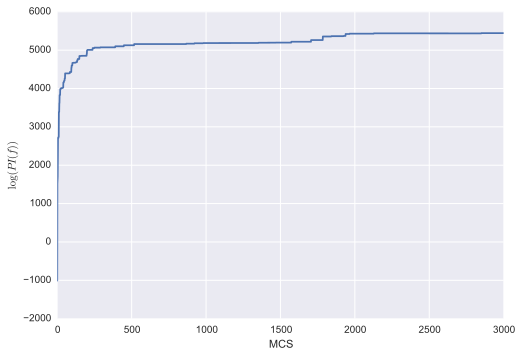

In [22]:
plt.plot(range(len(recP)), recP)
plt.xlabel('MCS')
plt.ylabel(r'$\log(PI(f))$')

From the trace plot of $\log(\mbox{PI})$ we can see that our result quickly converges on the answer. 

## A New Message

Another test to perform is to give the functions a different message and see if it could crack the code. Lets generate a new secret and apply a different mapping so it will be encrypted

In [24]:
moreSecrets = ('A FAKE SENTENCE TO TRY AND TEST OUT THE CODE ABOVE AND SEE HOW ' +
               'WELL IT PERFORMS WITH A DIFFERENT INPUT BUT ALSO MAKING SURE ' +
               'THAT IT LONG ENOUGH THAT WE CAN GET RESONABLE RESULTS IN A ' +
               'SHORT AMOUNT OF TIME')
another_map = get_map()
codedSecret = encrypt(moreSecrets, another_map)
codedSecret

'D CDTZ AZVGZVOZ GX GQU DVR GZAG XPG GNZ OXRZ DSXWZ DVR AZZ NXE EZLL YG KZQCXQFA EYGN D RYCCZQZVG YVKPG SPG DLAX FDTYVJ APQZ GNDG YG LXVJ ZVXPJN GNDG EZ ODV JZG QZAXVDSLZ QZAPLGA YV D ANXQG DFXPVG XC GYFZ'

Now our decryption method should work using the original mapping as a starting place

In [25]:
recP, results = samp_MC_decrypt(codedSecret, newM, myMap)
print results

Total run time: 00:01.88s
p = 2173.12854282
Acceptance Ratio = 4.93333333333%
A MAVE SENTENFE TO TRY AND TEST OUT THE FODE ABOKE AND SEE HOW WELL IT CERMORPS WITH A DIMMERENT INCUT BUT ALSO PAVING SURE THAT IT LONG ENOUGH THAT WE FAN GET RESONABLE RESULTS IN A SHORT APOUNT OM TIPE


It's done alright and the longer the sentence the better it will do.

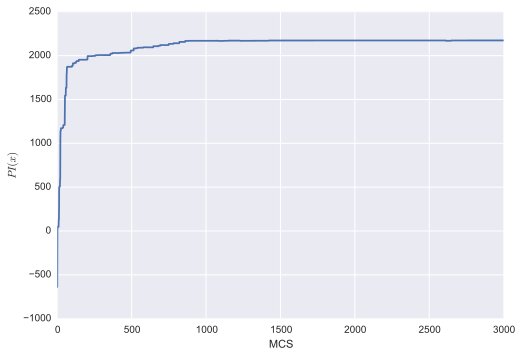

In [26]:
plt.plot(range(len(recP)), recP)
plt.xlabel('MCS')
plt.ylabel(r'$PI(x)$')

## Improvements

A major improvement to this method is to include more books in our generation of the pair frequency matrix. We were lucky that our message was actually contained in the books used. If that is not the case than having a wide variety of training texts is useful. 

One technique which was not explored would be to look at the single letter frequency in our inital message to pick a better inital mapping rather than just starting with a random mapping.

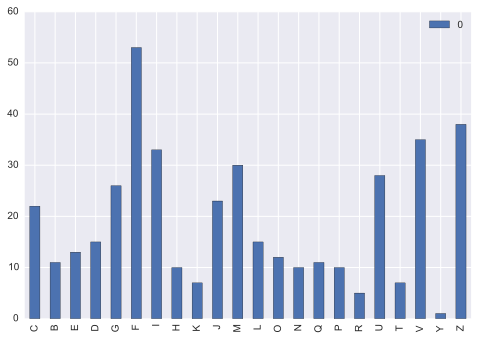

In [27]:
nospaces = ''.join([x for x in message.split()])
letter_counts = Counter(sorted(nospaces))
df = pandas.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

Matching this histogram with one of known frequencies could lead to a better initial mapping

## Conclusion

We cracked the code! Two methods were explored to perform our decryption. The first was an optimization technique where we reformulated the "likelihood" function to be additive instead of multiplicative. This led to a fast result but it was not reliable. Multiple runs were made and a most common output was determined to remedy this problem. Our secret message was found to be a passage from "Oliver Twist", one of the texts used to build our pair frequency matrix. The second approach was from a sampling perspective and worked using the methods outlined in the instructions. Working with log values introduced some difficulties at first but ultimatly the first method was adapted with relative ease. Using the sampling approach allowed for a much more stable result in a shorter amount of time. Our sampling method was then tested on a new secret that was not included in the texts to build the pair frequency matrix and still performed well. 